In [124]:
import pandas as pd
import numpy as np
import ast

In [41]:
df = pd.read_csv('all_prices_extracted_cleaned_categorized_analyzed.csv')

In [42]:
promotions = {
    'Saldos Verao': ['06','07', '08', '09'],
    'Saldos Inverno': ['01','02', '12'],
    'Black Friday': ['11'],
}

def create_promotion(row):
    # no caso do produto ter 2 precos na price_list, e na coluna promocao estiver como 'Sem promocao', e na data YYYYMMDD estiver dentro do periodo de promocao, entao a promocao sera a key do dicionario
    if row['min_price'] != row['max_price'] and row['promocao'] == 'Sem Promocao':
        for promotion, months in promotions.items():
            if str(row['date'])[4:6] in months:
                return promotion
    return row['promocao']


df['promocao'] = df.apply(create_promotion, axis=1)

In [43]:
# so quero guardar dados agora que tenham o site + categoria + brand + model + sub_model + color + HDD_size + RAM_size (msm que os sizes sejam None)
df = df[df.duplicated(subset=['site', 'categoria', 'brand', 'model', 'sub_model', 'color', 'HDD_size', 'RAM_size'], keep=False)]

feature_columns = [
    'site', 'promocao', 'categoria', 'price_list',
    'min_price', 'max_price', 'avg_price', 
    'price_variation', 'discount_percent', 
    'brand', 'model', 'sub_model', 'brand_model', 
    'color', 'HDD_size', 'RAM_size', 'date',
]

df = df[feature_columns]

 

In [44]:
categories = ['Smartphone', 'Consola', 'Computador', 'Tablet', 'Eletrodomesticos']

# apaga as rows em que a categoria nao esta na lista de categorias
df = df[df['categoria'].isin(categories)]



In [45]:
# apaga as row quando nao tem model e nao sao Eletrodomesticos
df = df[~(df['model'].isna() & (df['categoria'] != 'Eletrodomesticos'))]

# apaga os eletrodomesticos
df = df[df['categoria'] != 'Eletrodomesticos']

In [46]:
df.to_csv('ml_dataset.csv', index=False)

In [221]:
import matplotlib.pyplot as plt
import pmdarima as pm  
import warnings

warnings.filterwarnings('ignore')

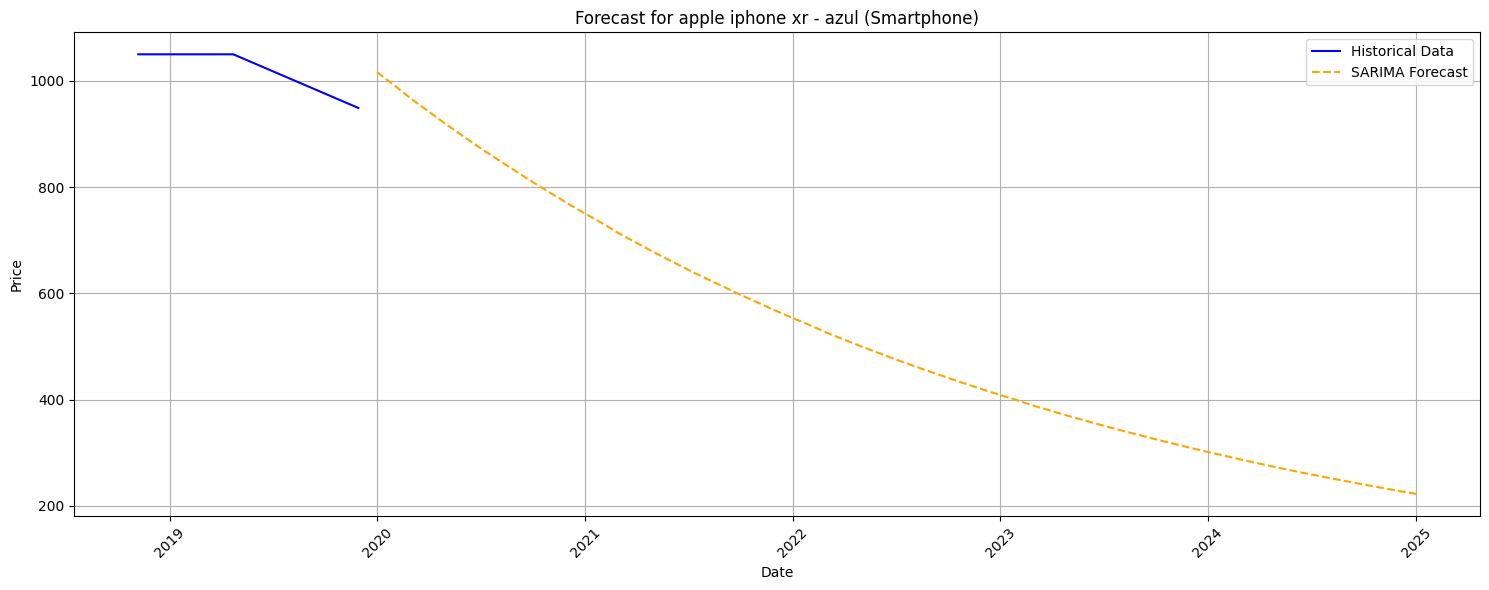

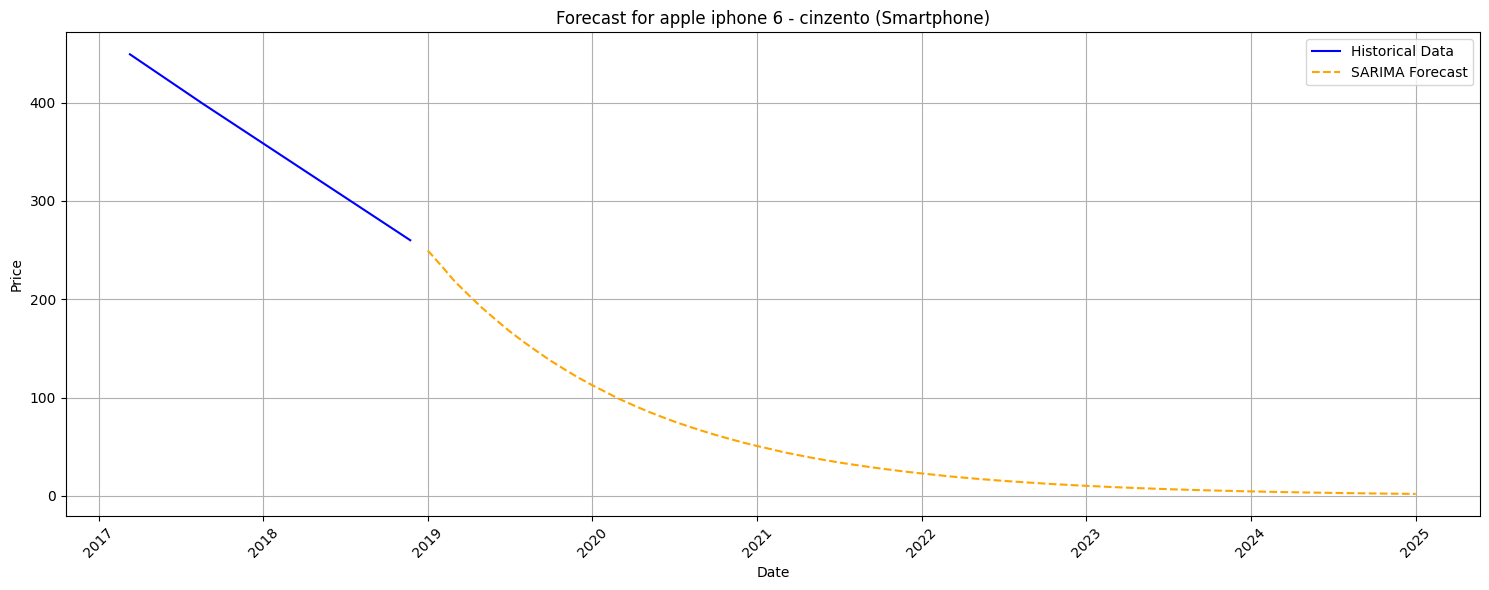

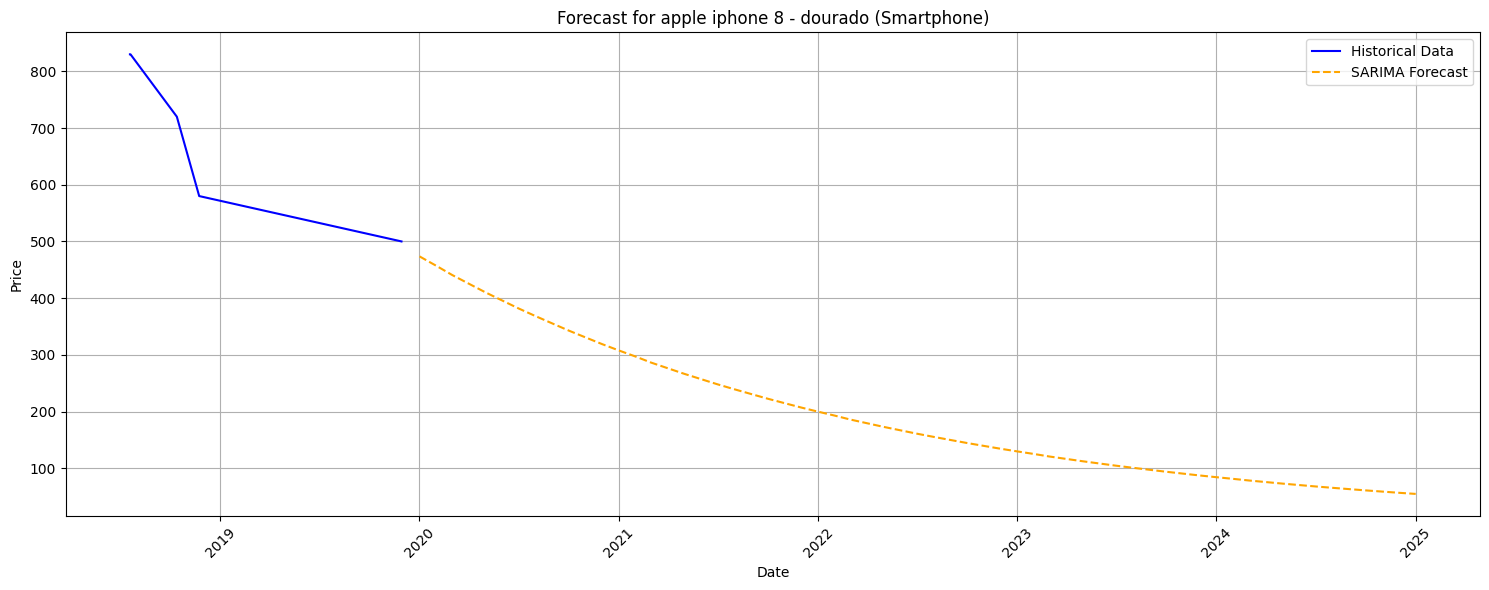

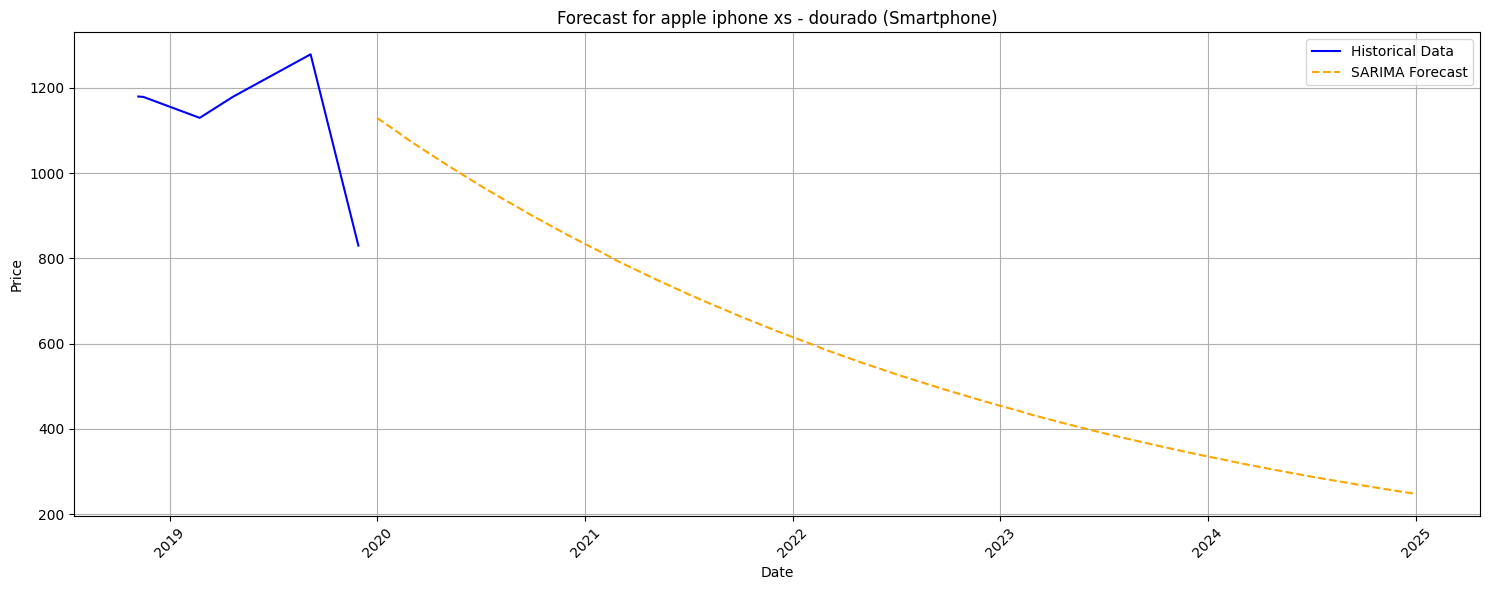

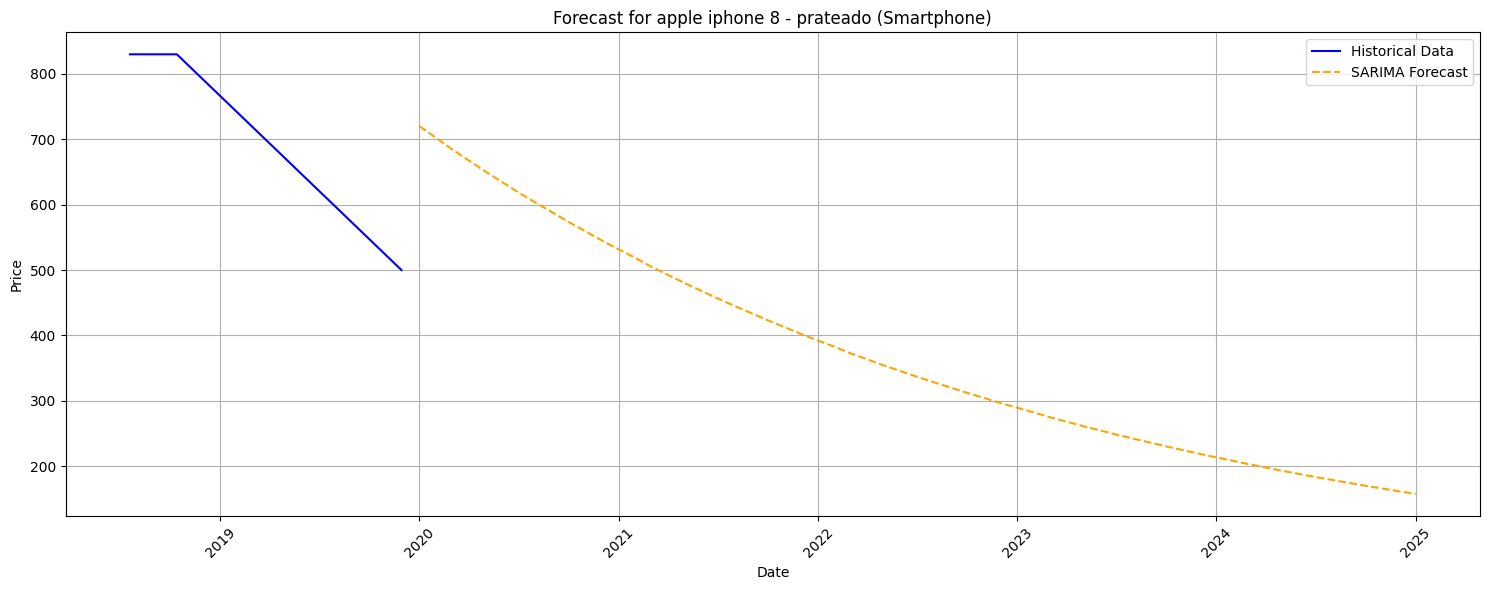

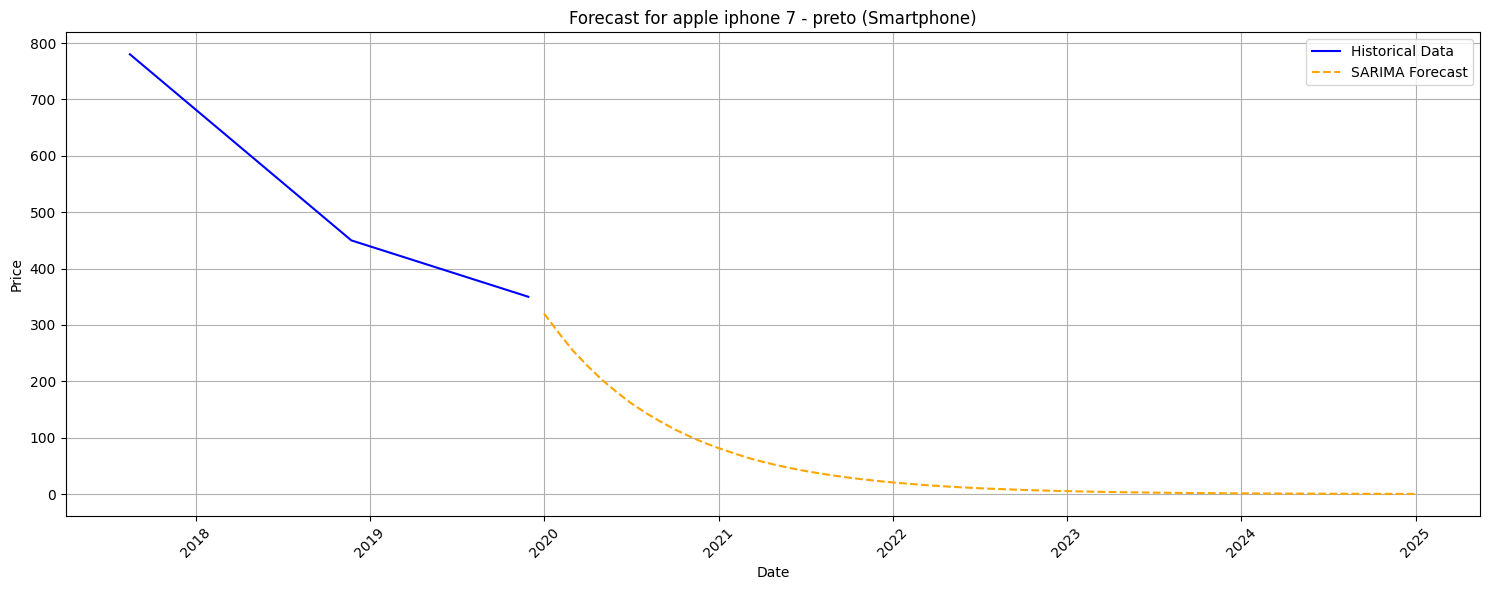

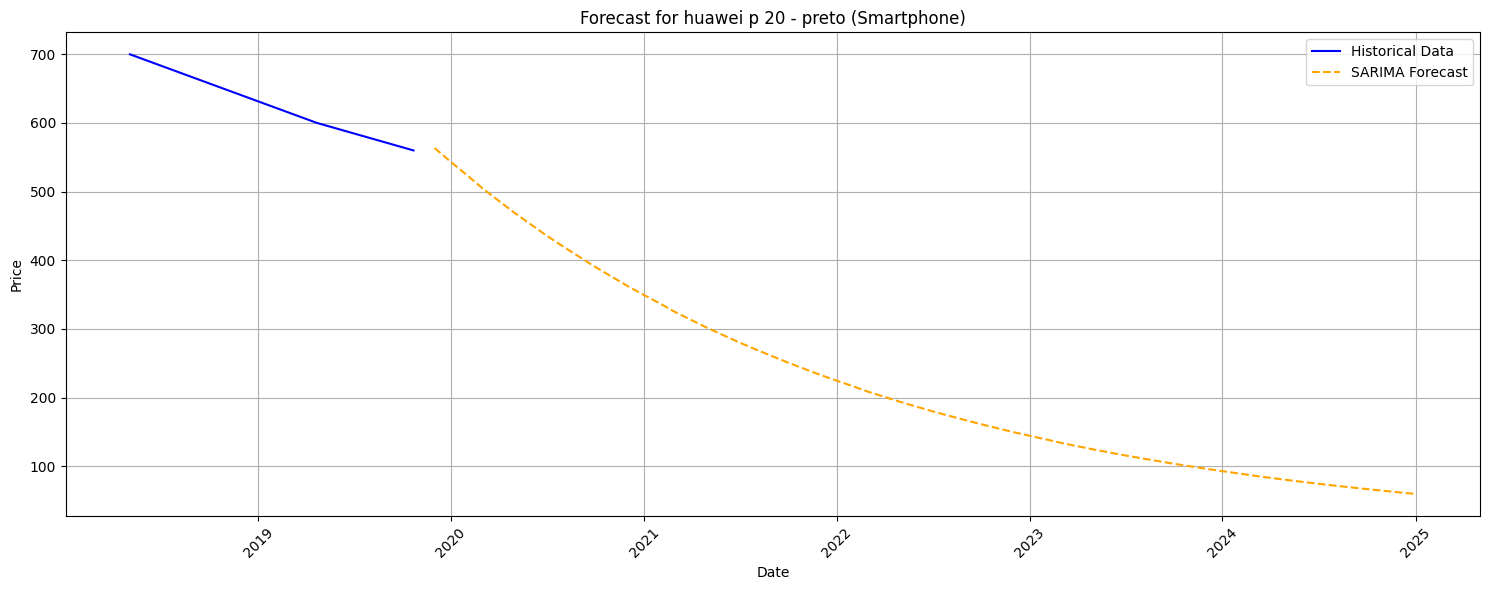

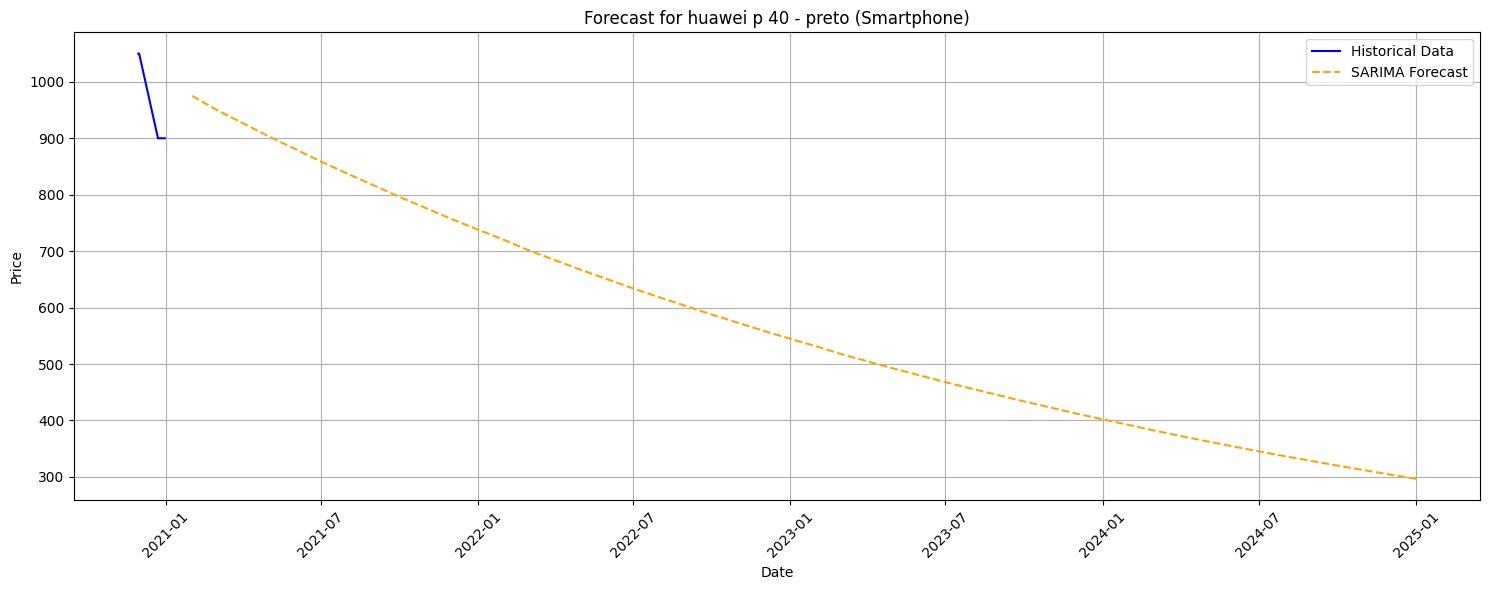

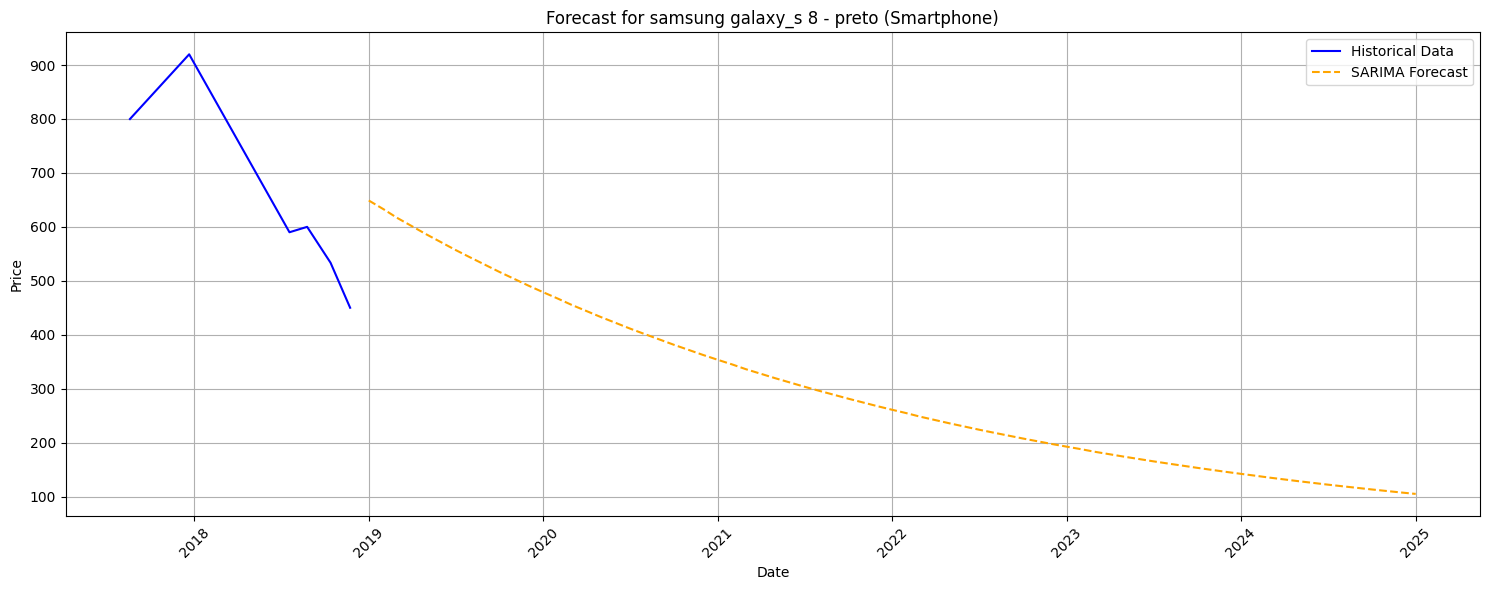

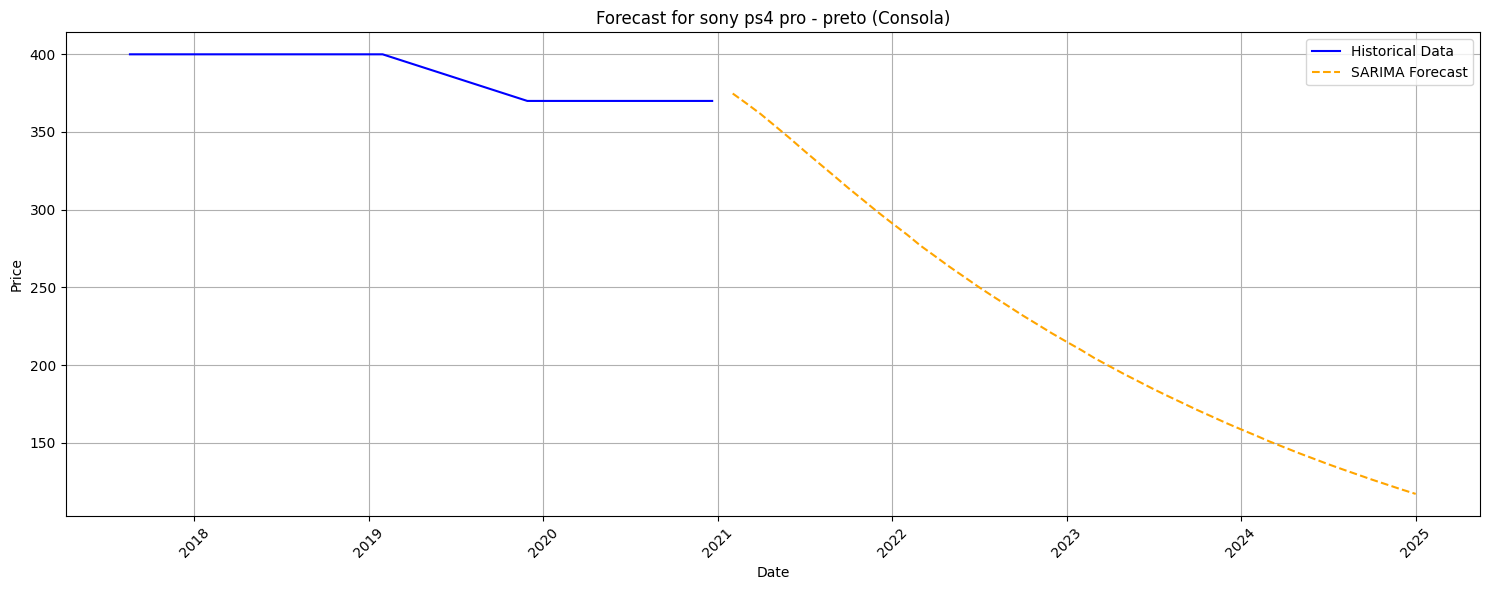

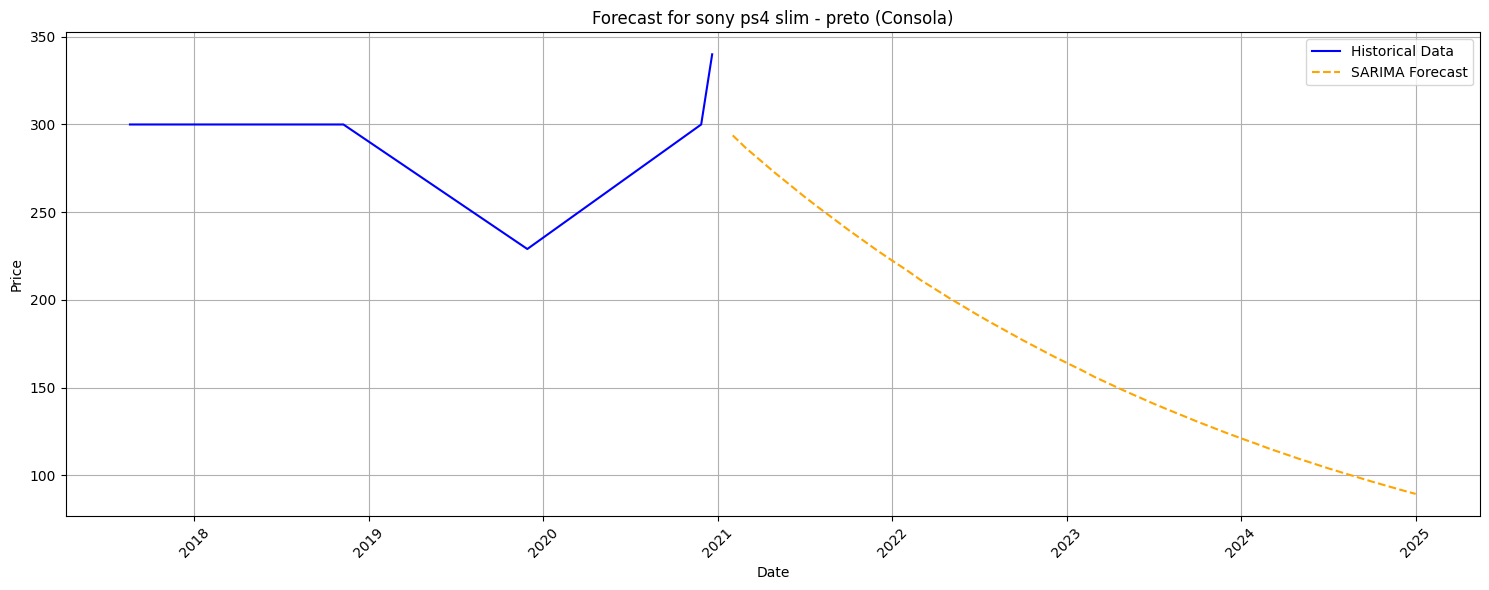

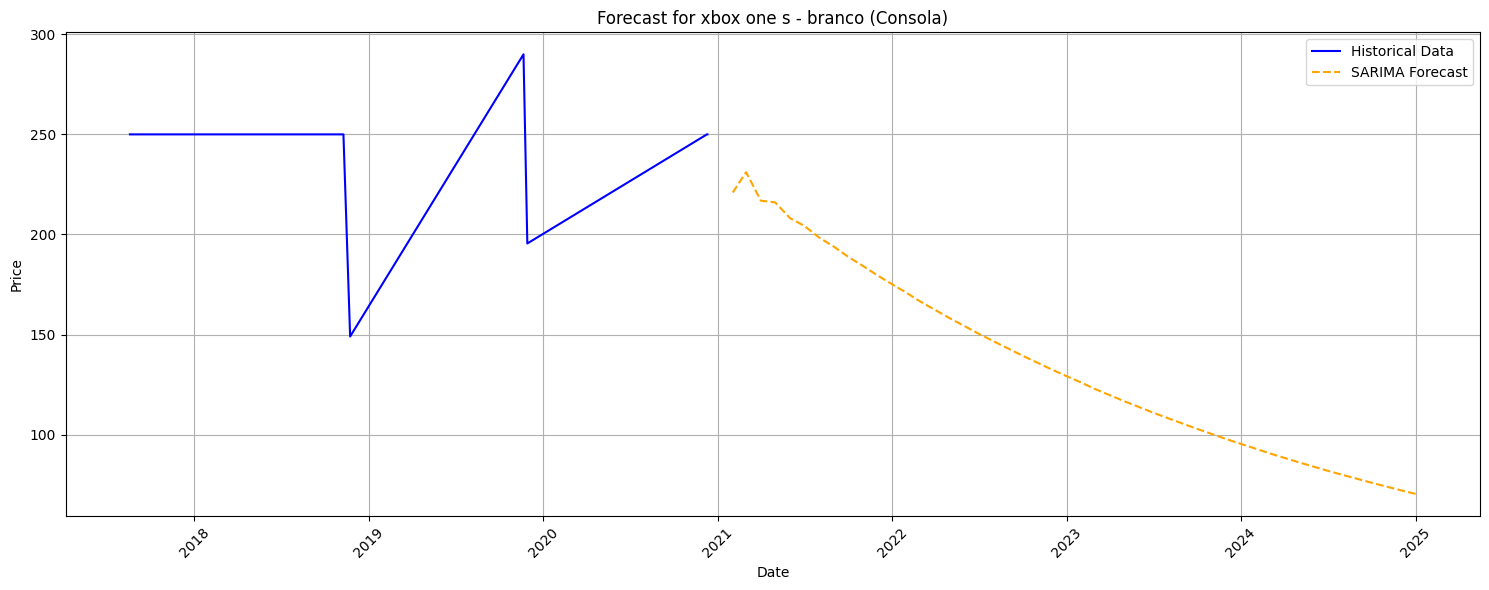

In [ ]:

df = pd.read_csv('dataset_produts_to_ml.csv')

df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')


def prepare_time_series(df, brand=None, model=None, color=None, category=None, brand_model=None):
    filtered_df = df.copy()
    
    if brand:
        filtered_df = filtered_df[filtered_df['brand'] == brand]
    if model:
        filtered_df = filtered_df[filtered_df['model'] == model]
    if color:
        filtered_df = filtered_df[filtered_df['color'] == color]
    if category:
        filtered_df = filtered_df[filtered_df['categoria'] == category]
    if brand_model:
        filtered_df = filtered_df[filtered_df['brand_model'] == brand_model]
    
    time_series = filtered_df.groupby('date')['min_price'].mean().reset_index()
    time_series.set_index('date', inplace=True)
    
    if time_series.empty or len(time_series) < 3:
        print("Not enough data available for ", brand, model, color, category, brand_model)
        return None
    
    return time_series


def forecast_time_series_sarima(time_series, forecast_periods):

    if len(time_series) < 2:
        print("Insufficient data for forecasting.")
        return None

    prices = time_series['min_price'].values

    try:
        sarima_model = pm.auto_arima(
            prices,
            seasonal=False,
            suppress_warnings=True,
            stepwise=True,
        )

        sarima_forecast, conf_int = sarima_model.predict(n_periods=forecast_periods, return_conf_int=True)

        # adicionei um decline de preço porque os preços dos produtos tendem a descer com o tempo
        decline_factor = 0.975
        sarima_forecast = sarima_forecast * (decline_factor ** np.arange(0, forecast_periods))

        return {
            'SARIMA': {
                'forecast': sarima_forecast,
                'conf_int': conf_int
            }
        }
    except Exception as e:
        print(f"SARIMA model error: {e}")
        return None


def analyze_products(df):

    unique_products = df.groupby(['brand', 'model', 'color', 'categoria', 'brand_model']).size().reset_index()

    forecasts = {}
    end_of_2024 = pd.Timestamp('2024-12-31')
    
    for _, product in unique_products.iterrows():
        time_series = prepare_time_series(
            df, 
            brand=product['brand'], 
            model=product['model'], 
            color=product['color'],
            category=product['categoria'],
            brand_model=product['brand_model']
        )

        if time_series is None:
            continue
        
        last_date = time_series.index[-1]
        forecast_periods = (end_of_2024.year - last_date.year) * 12 + (end_of_2024.month - last_date.month)
        
        if forecast_periods <= 0:
            print(f"No forecasting needed for {product['brand']} {product['model']} {product['color']} ({product['categoria']} {product['brand_model']})")
            continue
        
        product_forecasts = forecast_time_series_sarima(time_series, forecast_periods)
        
        if product_forecasts:
            product_key = f"{product['brand']} {product['brand_model']} - {product['color']} ({product['categoria']})"
            forecasts[product_key] = {
                'time_series': time_series,
                'forecasts': product_forecasts
            }

    return forecasts


def visualize_forecasts(product_forecasts):
    for product, forecast_data in product_forecasts.items():
        plt.figure(figsize=(15, 6))
        
        time_series = forecast_data['time_series']
        forecasts = forecast_data['forecasts']
        
        plt.plot(time_series.index, time_series['min_price'], label='Historical Data', color='blue')

        if 'SARIMA' in forecasts:
            forecast_dates = pd.date_range(
                start=time_series.index[-1] + pd.DateOffset(months=1), periods=len(forecasts['SARIMA']['forecast']), freq='MS')
            plt.plot(forecast_dates, forecasts['SARIMA']['forecast'], label='SARIMA Forecast', linestyle='--', color='orange')
        
        plt.title(f"Forecast for {product}")
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


product_forecasts = analyze_products(df)

visualize_forecasts(product_forecasts)


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [ ]:
class ProductPricePrediction:
    def __init__(self, df):
        self.df = df

        self.numeric_features = ['HDD_size', 'RAM_size']
        self.categorical_features = ['site', 'categoria', 'brand', 'brand_model', 'color']

        # processar promocao em binario
        self.df['promocao'] = self.df['promocao'].apply(lambda x: 0 if x == 'Sem Promocao' else 1)

        # adicionar 'promocao' as features numéricas após a transformação
        self.numeric_features.append('promocao')

        # scaler para normalizar os valores numéricos, one-hot encoder para as features categóricas
        # impute com os valores mais frequentes para as features categoricas e com a media para as features numericas
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', Pipeline([
                    ('imputer', SimpleImputer(strategy='mean')),
                    ('scaler', StandardScaler())
                ]), self.numeric_features),
                ('cat', Pipeline([
                    ('imputer', SimpleImputer(strategy='most_frequent')),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'))
                ]), self.categorical_features)
            ]
        )

        self.price_model = Pipeline([
            ('preprocessor', self.preprocessor),
            ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
        ])

    def prepare_data(self, price_column='max_price'):
        """Prepara os dados para treino."""
        # dar input de valores medianos para os valores nulos
        self.df[price_column] = self.df[price_column].fillna(self.df[price_column].median())

        # dividir em features e target, o target é o max preço
        X = self.df.drop([price_column], axis=1)
        y = self.df[price_column]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        return X_train, X_test, y_train, y_test

    def train_model(self):
        """Treina o modelo para prever os preços."""
        X_train, X_test, y_train, y_test = self.prepare_data()

        self.price_model.fit(X_train, y_train)
        predictions = self.price_model.predict(X_test)

        print("Price Prediction Metrics:")
        print(f"MAE: {mean_absolute_error(y_test, predictions)}")
        print(f"MSE: {mean_squared_error(y_test, predictions)}")
        print(f"R2 Score: {r2_score(y_test, predictions)}")

    def predict_price(self, product_data):
        """Faz a previsão do preço com base nas características do produto."""
        input_df = pd.DataFrame([product_data])
        predicted_price = self.price_model.predict(input_df)[0]
        return predicted_price


In [61]:
df = pd.read_csv('ml_dataset.csv')

predictor = ProductPricePrediction(df)
predictor.train_model()

tentativa = {
    'site': 'fnac',
    'promocao': 0, 
    'categoria': 'Smartphone',
    'brand': 'apple',
    'brand_model': 'iphone 15',
    'color': 'preto',
    'HDD_size': 64,
    'RAM_size': 16
}

predicted_price = predictor.predict_price(tentativa)
print("\nProduct Price Prediction:")
print(f"Predicted Price: ${predicted_price:.2f}")


Price Prediction Metrics:
MAE: 110.5099292110814
MSE: 29171.423524042755
R2 Score: 0.9071862531024377

Product Price Prediction:
Predicted Price: $617.26
